In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


# EDA MODELO MACHINE LEARNING def (recomendacion_juego).


### Creo los dataframes producto de los archivos .parquet para seleccionar y concatenar los campos necesarios para empezar el analisis y posteriormente la función del modelo MC.

In [2]:
df_steam_games = pd.read_parquet('steam_games.parquet')
df_steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21194 entries, 0 to 21193
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     21194 non-null  object        
 1   genres        21194 non-null  object        
 2   app_name      21194 non-null  object        
 3   title         21194 non-null  object        
 4   url           21194 non-null  object        
 5   release_date  21194 non-null  datetime64[ns]
 6   tags          21194 non-null  object        
 7   reviews_url   21194 non-null  object        
 8   specs         21194 non-null  object        
 9   price         21194 non-null  float64       
 10  early_access  21194 non-null  float64       
 11  id            21194 non-null  float64       
 12  developer     21194 non-null  object        
 13  num_reviews   21194 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(9)
memory usage: 2.3+ MB


In [3]:
df_user_reviews = pd.read_parquet('user_reviews.parquet')
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             25771 non-null  object        
 1   user_url            25771 non-null  object        
 2   item_id             25771 non-null  int64         
 3   helpful             25771 non-null  object        
 4   recommend           25771 non-null  bool          
 5   posted_date         25771 non-null  datetime64[ns]
 6   sentiment_analysis  25771 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 1.2+ MB


In [4]:
df_users_items = pd.read_parquet('users_items.parquet')
df_users_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88176 entries, 0 to 88175
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           88176 non-null  object 
 1   items_count       88176 non-null  float64
 2   steam_id          88176 non-null  object 
 3   user_url          88176 non-null  object 
 4   item_id           88176 non-null  int64  
 5   item_name         88176 non-null  object 
 6   playtime_forever  88176 non-null  float64
 7   playtime_2weeks   88176 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 5.4+ MB


### Concateno los campos seleccionados para el modelo MC. los cuales son:
### item_id, title, genres, tags, playtime_forever,developer.

In [55]:

# Selecciono los campos requeridos para la función MC
df_steam_games_subset = df_steam_games[['tags', 'genres', 'developer', 'title']]
df_user_reviews_subset = df_user_reviews[['item_id', 'sentiment_analysis']]
df_users_items_subset = df_users_items[[ 'playtime_forever']]

# Concateno los DataFrames seleccionados
df_mcf = pd.concat([df_steam_games_subset, df_user_reviews_subset, df_users_items_subset], axis=1)

df_mcf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88176 entries, 0 to 88175
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tags                21194 non-null  object 
 1   genres              21194 non-null  object 
 2   developer           21194 non-null  object 
 3   title               21194 non-null  object 
 4   item_id             25771 non-null  float64
 5   sentiment_analysis  25771 non-null  float64
 6   playtime_forever    88176 non-null  float64
dtypes: float64(3), object(4)
memory usage: 4.7+ MB


### Elimino datos faltantes producto de las diferentes longitudes en la concatenación

In [56]:
df_mcf.dropna(inplace=True)
df_mcf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21194 entries, 0 to 21193
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tags                21194 non-null  object 
 1   genres              21194 non-null  object 
 2   developer           21194 non-null  object 
 3   title               21194 non-null  object 
 4   item_id             21194 non-null  float64
 5   sentiment_analysis  21194 non-null  float64
 6   playtime_forever    21194 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.3+ MB


### Reorganizo los indices despues de eliminar los datos faltantes

In [57]:
# Reorganizo los indices despues de la eliminación de datos faltantes
df_mcf.reset_index(drop=True, inplace=True)
print(df_mcf.index)

RangeIndex(start=0, stop=21194, step=1)


### Reviso la distribución del campo genre

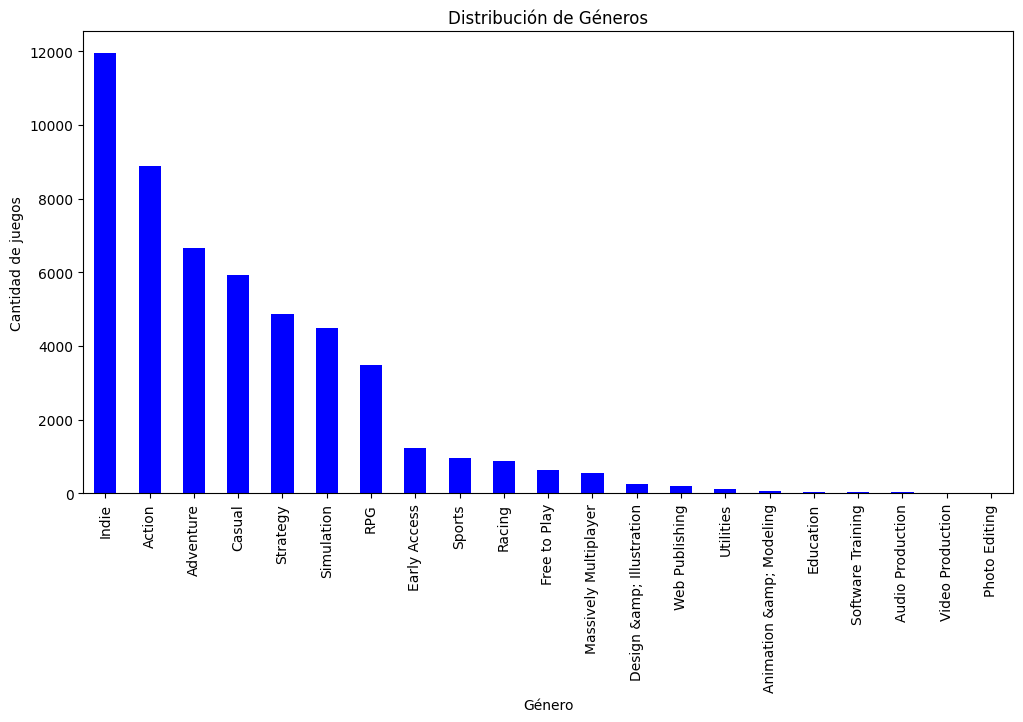

In [58]:


# Expando las listas de géneros y creo una nueva fila por cada género en la lista.
df_exploded = df_mcf.explode('genres')

# Cuento la frecuencia de cada género.
genre_counts = df_exploded['genres'].value_counts()

# Creo la gráfica de distribución.
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='blue')
plt.xlabel('Género')
plt.ylabel('Cantidad de juegos')
plt.title('Distribución de Géneros')
plt.xticks(rotation=90)
plt.show()


### Realizo una tabla en pandas para revisar la relación entre item_id, title y genre.

In [64]:



# Selecciono los campos 'item_id', 'title' y 'genre' y creo un nuevo DataFrame con ellos.
item_relation = df_mcf[['item_id', 'title', 'genres']]

# Muestro la tabla de relación entre 'item_id', 'title' y 'genres'.
item_relation


,item_id,title,genres
0,43110.0,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]"
1,239030.0,弹炸人2222,"[Action, Adventure, Casual]"
2,224500.0,Battle Royale Trainer,"[Action, Adventure, Simulation]"
3,108710.0,SNOW - All Access Pro Pass,"[Free to Play, Indie, Simulation, Sports]"
4,204300.0,SNOW - All Access Legend Pass,"[Free to Play, Indie, Simulation, Sports]"
...,...,...,...
21189,8930.0,Kebab it Up!,"[Action, Adventure, Casual, Indie]"
21190,440.0,Colony On Mars,"[Casual, Indie, Simulation, Strategy]"
21191,468410.0,LOGistICAL: South Africa,"[Casual, Indie, Strategy]"
21192,4000.0,Russian Roads,"[Indie, Racing, Simulation]"


In [60]:


# Separo las listas de géneros en filas separadas.
df_genres = df_mcf.explode('genres')

df_genres[['item_id', 'title', 'genres']]


,item_id,title,genres
0,43110.0,Lost Summoner Kitty,Action
0,43110.0,Lost Summoner Kitty,Casual
0,43110.0,Lost Summoner Kitty,Indie
0,43110.0,Lost Summoner Kitty,Simulation
0,43110.0,Lost Summoner Kitty,Strategy
...,...,...,...
21192,4000.0,Russian Roads,Indie
21192,4000.0,Russian Roads,Racing
21192,4000.0,Russian Roads,Simulation
21193,730.0,EXIT 2 - Directions,Casual


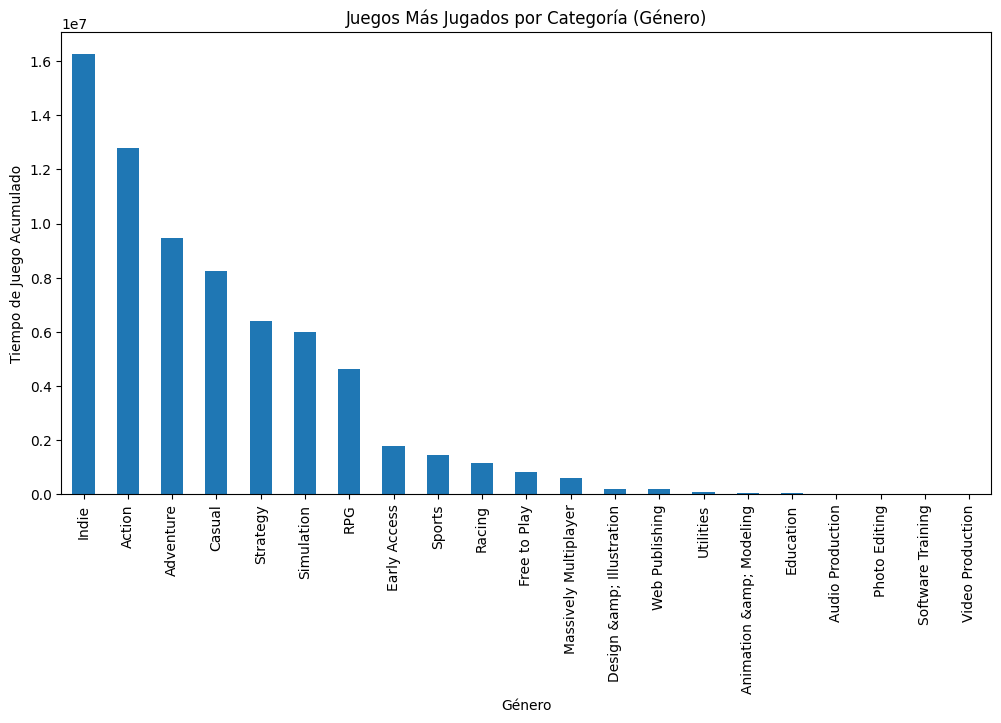

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado df_mc que contiene los datos.

# Separa las listas de géneros en filas separadas.
df_genres = df_mcf.explode('genres')

# Agrupa por género y suma el tiempo de juego acumulado.
genre_playtime = df_genres.groupby('genres')['playtime_forever'].sum()

# Ordena los géneros por el tiempo de juego acumulado.
genre_playtime = genre_playtime.sort_values(ascending=False)

# Crea la gráfica de barras.
plt.figure(figsize=(12, 6))
genre_playtime.plot(kind='bar')
plt.title('Juegos Más Jugados por Categoría (Género)')
plt.xlabel('Género')
plt.ylabel('Tiempo de Juego Acumulado')
plt.xticks(rotation=90)
plt.show()


### Reviso la estadistica descriptivas para las variables numericas

In [61]:
df_mcf.describe()

,item_id,sentiment_analysis,playtime_forever
count,21194.000000,21194.000000,21194.000000
mean,154977.698547,1.385628,1354.077947
std,131324.840312,0.795971,7628.226474
min,10.000000,0.000000,0.000000
25%,4000.000000,1.000000,0.000000
50%,208090.000000,2.000000,45.000000
75%,250900.000000,2.000000,389.000000
max,527340.000000,2.000000,303466.000000


### La desviación estándar alta: La desviación estándar de playtime_forever es bastante alta en comparación con la media. Esto sugiere que los valores están muy dispersos, y algunos juegos pueden tener un tiempo de juego significativamente mayor que la mayoría. Esto podría deberse a la presencia de "outliers" o valores atípicos.

### Genero una grafica boxplot del campo playtime_forever.

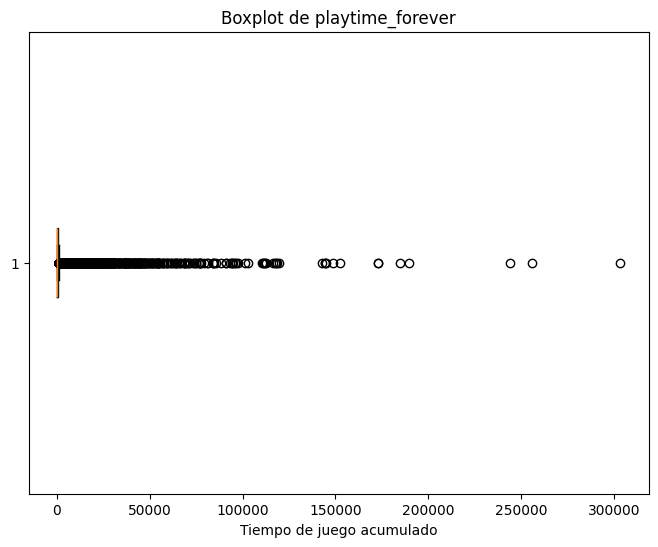

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado df_mc que contiene los datos.

# Crea un boxplot para la columna 'playtime_forever'.
plt.figure(figsize=(8, 6))
plt.boxplot(df_mcf['playtime_forever'], vert=False)
plt.title('Boxplot de playtime_forever')
plt.xlabel('Tiempo de juego acumulado')
plt.show()


### Reviso en una tabla de pandas el playtime forever por genero para revisar que se trata de un dato no atipico . pues el playtime_forever son los minutos acumulados de juego.

In [54]:


# Separo las listas de géneros en filas separadas.
df_genres = df_mcf.explode('genres')

# Agrupo por género y sumo el tiempo de juego acumulado en minutos.
genre_playtime = df_genres.groupby('genres')['playtime_forever'].sum() / 60  # Dividir por 60 para convertir a minutos.

# Creo una nueva DataFrame para mostrar el tiempo total de juego por género en minutos.
table = pd.DataFrame({'Género': genre_playtime.index, 'Tiempo Total (minutos)': genre_playtime.values})

# Muestra la tabla.
table


,Género,Tiempo Total (minutos)
0,Action,212999.583333
1,Adventure,158069.233333
2,Animation &amp; Modeling,917.900000
3,Audio Production,561.866667
4,Casual,137571.816667
5,Design &amp; Illustration,3429.200000
6,Early Access,30094.733333
7,Education,599.133333
8,Free to Play,13893.466667
9,Indie,270686.166667


### El tiempo de juego acumulado puede variar significativamente entre diferentes juegos y géneros, y valores extremadamente altos pueden ser representativos de usuarios que han invertido mucho tiempo en un juego en particular. descarto la posibilidad de un outliers en playtime_forever.

### Genero una gráfica de barras para ver el sentimiento en relación con el genero

<Figure size 1200x600 with 0 Axes>

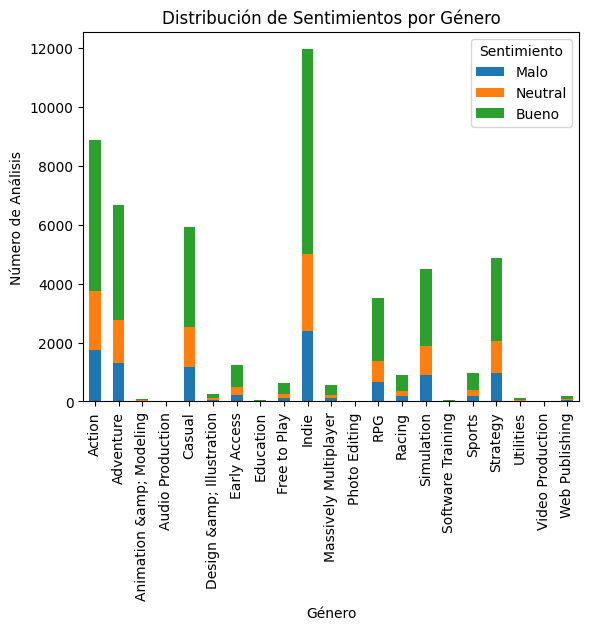

In [68]:



# Expando la lista de géneros en filas separadas.
df_expanded = df_mcf.explode('genres')

# Agrupo por género y sentimiento, y cuento el número de análisis en cada categoría.
sentiment_counts = df_expanded.groupby(['genres', 'sentiment_analysis']).size().unstack(fill_value=0)

# Reordeno las columnas para que los sentimientos aparezcan en el orden correcto (0, 1, 2).
sentiment_counts = sentiment_counts[[0, 1, 2]]

# Creo un gráfico de barras apiladas.
plt.figure(figsize=(12, 6))
sentiment_counts.plot(kind='bar', stacked=True)
plt.title('Distribución de Sentimientos por Género')
plt.xlabel('Género')
plt.ylabel('Número de Análisis')
plt.xticks(rotation=90)
plt.legend(title='Sentimiento', labels=['Malo', 'Neutral', 'Bueno'])

plt.show()


In [69]:
df_mcf

,tags,genres,developer,title,item_id,sentiment_analysis,playtime_forever
0,"[Strategy, Action, Indie, Casual, Simulation]","[Action, Casual, Indie, Simulation, Strategy]",Kotoshiro,Lost Summoner Kitty,43110.0,2.0,6.0
1,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",彼岸领域,弹炸人2222,239030.0,0.0,0.0
2,"[Action, Adventure, Simulation, FPS, Shooter, ...","[Action, Adventure, Simulation]",Trickjump Games Ltd,Battle Royale Trainer,224500.0,2.0,7.0
3,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]",Poppermost Productions,SNOW - All Access Pro Pass,108710.0,2.0,0.0
4,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]",Poppermost Productions,SNOW - All Access Legend Pass,204300.0,2.0,0.0
...,...,...,...,...,...,...,...
21189,"[Action, Indie, Casual, Violent, Adventure]","[Action, Adventure, Casual, Indie]",Bidoniera Games,Kebab it Up!,8930.0,0.0,269.0
21190,"[Strategy, Indie, Casual, Simulation]","[Casual, Indie, Simulation, Strategy]","Nikita ""Ghost_RUS""",Colony On Mars,440.0,2.0,0.0
21191,"[Strategy, Indie, Casual]","[Casual, Indie, Strategy]",Sacada,LOGistICAL: South Africa,468410.0,2.0,754.0
21192,"[Indie, Simulation, Racing]","[Indie, Racing, Simulation]",Laush Dmitriy Sergeevich,Russian Roads,4000.0,0.0,0.0


In [70]:
df_mcf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21194 entries, 0 to 21193
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tags                21194 non-null  object 
 1   genres              21194 non-null  object 
 2   developer           21194 non-null  object 
 3   title               21194 non-null  object 
 4   item_id             21194 non-null  float64
 5   sentiment_analysis  21194 non-null  float64
 6   playtime_forever    21194 non-null  float64
dtypes: float64(3), object(4)
memory usage: 1.1+ MB


### Testing función (recomendacion_juego)

In [74]:


# Paso 1: Preproceso los datos
# uso el campo 'genres' para calcular la similitud de coseno. 

# Paso 2: Creo una matriz TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_mcf['genres'].apply(lambda x: ' '.join(x)))

# Paso 3: Calculo la similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Paso 4: Defino la función de recomendación
def recomendacion_juego(item_id, cosine_sim=cosine_sim):
    # Encuentro el índice del juego en función de su item_id.
    idx = df_mcf[df_mcf['item_id'] == item_id].index[0]

    # Calculo la puntuación de similitud de coseno para todos los juegos con el juego dado.
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Ordeno los juegos según su puntuación de similitud.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Obtengo los índices de los juegos más similares (excluyendo el juego dado).
    sim_scores = sim_scores[1:6]

    # Obtengo los títulos de los juegos recomendados.
    game_indices = [i[0] for i in sim_scores]
    recommended_games = df_mcf['title'].iloc[game_indices]

    return recommended_games


item_id = 43110.0  
recomendaciones = recomendacion_juego(item_id)
print(recomendaciones)


2663             Pixel Puzzles 2: Anime
2795    World of Cinema - Directors Cut
3986             Toy Soldiers: Complete
4913     Pixel Puzzles 2: RADical ROACH
6541                 Aerial Destruction
Name: title, dtype: object


### Exporto la data para generar la función del modelo MC en el main.py

In [75]:
# Cargo la  data desde el archivo Parquet

# Especifico la ubicación y el nombre del archivo Parquet 
archivo_parquet = "data_mc.parquet"

# Utilizo el método to_parquet para guardar el DataFrame en un archivo Parquet.
df_mcf.to_parquet(archivo_parquet, index=False)


In [76]:
prueba = pd.read_parquet('data_mc.parquet')
prueba.head()

,tags,genres,developer,title,item_id,sentiment_analysis,playtime_forever
0,"[Strategy, Action, Indie, Casual, Simulation]","[Action, Casual, Indie, Simulation, Strategy]",Kotoshiro,Lost Summoner Kitty,43110.0,2.0,6.0
1,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",彼岸领域,弹炸人2222,239030.0,0.0,0.0
2,"[Action, Adventure, Simulation, FPS, Shooter, ...","[Action, Adventure, Simulation]",Trickjump Games Ltd,Battle Royale Trainer,224500.0,2.0,7.0
3,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]",Poppermost Productions,SNOW - All Access Pro Pass,108710.0,2.0,0.0
4,"[Free to Play, Indie, Simulation, Sports]","[Free to Play, Indie, Simulation, Sports]",Poppermost Productions,SNOW - All Access Legend Pass,204300.0,2.0,0.0
